# Importing & Configurations

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy

In [2]:
datadir = './data'
outdir = './output'

# Define functions

In [3]:
def fill_limit(ax, datafile, label, color, alpha=1., delimiter=',', xdata_log=True, ydata_log=True, mass_scale=1., chi_scale=1.):
    mass, chi = np.loadtxt(datafile, delimiter = delimiter, unpack = True)
    if xdata_log : mass = np.power(10., mass)
    if ydata_log : chi  = np.power(10., chi)
    mass *= mass_scale
    chi  *= chi_scale
    ax.plot(mass, chi, label=label, color=color)
    upper = np.full(len(mass), 1.)
    ax.plot(mass, upper, color=color)
    ax.fill_between(mass, chi, upper, color=color, alpha=alpha)
    return 0

In [4]:
def draw_plot(drawLegend=True, drawText=True):
    fig = plt.figure(figsize=(7,4))
    ax = fig.add_subplot(1,1,1)
    
    fill_limit(ax, f"{datadir}/HPDM_by_shugo.txt", "Cosmological Limit", 'c', 0.2, mass_scale=1e+3)

    fill_limit(ax, f"{datadir}/Redo_rev.txt", "Solar Lifetime", 'r', 0.2, mass_scale=1e+3)

    fill_limit(ax, f"{datadir}/Haloscope_blue_0.txt", "Haloscope", 'b', 0.4, mass_scale=1e+3)
    fill_limit(ax, f"{datadir}/Haloscope_blue_1.txt", None, 'b', 0.4, mass_scale=1e+3)
    fill_limit(ax, f"{datadir}/Haloscope_blue_2.txt", None, 'b', 0.4, mass_scale=1e+3)

    #fill_limit(ax, f"{datadir}/suzuki_hpdm.txt", 'Suzuki et al.', 'g', 0.4, mass_scale=1e+3)

    fill_limit(ax, f"{datadir}/result_raw.txt", 'Tomita et al.', 'k', 1.0, delimiter=None, xdata_log=False, ydata_log=False, mass_scale=1.e-6*1e+3)

    if drawText:
        ax.set_xlabel("Dark photon mass $m_\gamma$ [meV]", fontsize = 14)
        ax.set_ylabel("Mixing parameter χ", fontsize = 14)
        ax.set_title("Constraints for DP-CDM at 95 % confidence level", fontsize = 15)
        pass
    ax.set_xlim(10 ** -3, 10 ** 2)
    #ax.set_xlim(10 ** -6, 10 ** -1)
    ax.set_ylim(10 ** -11, 10 ** -8)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.get_xaxis().set_tick_params(labelsize=16)
    ax.get_yaxis().set_tick_params(labelsize=16)
    plt.tight_layout()
    if drawLegend: ax.legend()
    return fig, ax

# Draw current exclusion limit

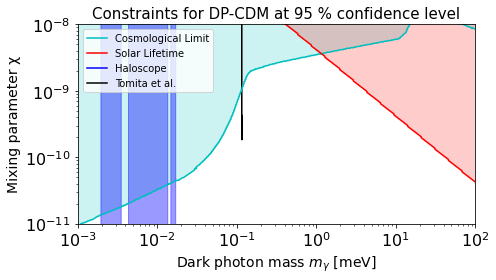

In [5]:
fig, ax = draw_plot()

# Calculate the expected sensitivity

### Assumption for NEP calculation

In [31]:
k_B = 1.380649e-23  # boltzmann const. [J/K]
Trx = 100 # Trx # DSB Trx is < 100K  for Nagoya SIS mixer from ミリ波受信機ワークショップ
dnu = (200. * 1.e+9) * 1.e-6 # Peak width [Hz]
Tload = 300 * 2# Maximum Tload x 2 (due to DSB)
#Tload = 100 # Tload is supposed to be 100K.
#Tload = 20 # Tload is supposed to be 20K.
time = 60 # sec
Aeff = (0.71/2.)**2*np.pi*0.5 # cm^2 # phi=0.71cm (VDI horn)
#Aeff = (3./2.)**2*np.pi*0.5 # cm^2 # phi=3cm
#Aeff = (5./2.)**2*np.pi*0.5 # cm^2 # phi=5cm
Aeff_m = Aeff * 1.e-4 # m^2
rho_CDM = 0.3 # GeV/cm^2
alpha = np.sqrt(1./3.)

### NEP calculation

$$
\begin{align}
 T_{noise} &= T_{RX} + T_{load} \tag{5}\label{a} \\
 P_{noise} &= k_B T_{noise} \Delta \nu \tag{6}\label{b}
\end{align}
$$

<br>
<br>
$$
\begin{align}
 NEP &= \sqrt{2 P_{noise} k_B T_{noise}} \\
\mathrm{(\ref{b}) より}  &  \\
     &= \sqrt{2\Delta\nu} k_B T_{noise} \\
     &= \sqrt{2\Delta\nu} k_B (T_{rx}+T_{load}) \\
\end{align}
$$
注) $\sqrt{2}$ は $NEP$ が 0.5 sec の時間積分でのノイズを表しているため。

In [32]:
NEP = np.sqrt(2.*dnu) * k_B * (Trx + Tload) 
print(f'NEP = {NEP:e} [W/sqrt(Hz)]')

NEP = 6.112394e-18 [W/sqrt(Hz)]


## $\chi$ calculation
$$
\chi = 4.5 \times 10^{-14} 
 \left( \frac{P_{\gamma^{\prime}}}{10^{-23} \mathrm{W}} \right)^{1/2} 
 \left( \frac{1 \mathrm{m}^2}{A_{\mathrm{eff}}} \right)^{1/2} 
 \left( \frac{0.3 \mathrm{GeV/cm}^{3}}{\rho_{\mathrm{CDM,halo}}} \right)^{1/2} 
 \left( \frac{\sqrt{2/3}}{\alpha} \right)
$$

In [33]:
dP = NEP/np.sqrt(time)
chi = 4.5e-14 * np.sqrt( dP/1.e-23 *  1/Aeff_m * 0.3/rho_CDM ) * np.sqrt(2./3.) / alpha
print(f'dP = {dP:e} [W]')
print(f'chi = {chi:e}')

dP = 7.891066e-19 [W]
chi = 4.017973e-09


In [20]:
def freq_to_eV(freq_GHz): return 4.137e-6 * freq_GHz;

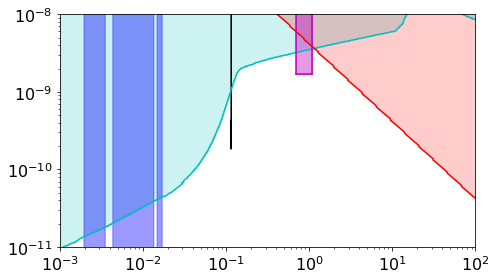

In [21]:
#drawText=True
drawText=False
fig, ax = draw_plot(drawLegend=False, drawText=drawText)

freq_min = 170. # GHz
freq_max = 260. # GHz
mass_min = freq_to_eV(freq_min)*1e+3 # meV
mass_max = freq_to_eV(freq_max)*1e+3 # meV
x = [mass_min, mass_max]
y1 = [chi, chi]
y2 = [1., 1.]

ax.fill_between(x, y1, y2, color="m", alpha=0.4)
ax.plot([mass_min,mass_min], [chi,1.], color="m")
ax.plot([mass_max,mass_max], [chi,1.], color="m")
ax.plot(x, y1, color="m")
xlim = ax.get_xlim()
ylim = ax.get_ylim()
if drawText:
    ax.text(10.**np.mean(np.log10(xlim))*0.1,5*ylim[0], f't={time} sec for each band', fontsize=14)
    ax.text(10.**np.mean(np.log10(xlim))*0.1,2*ylim[0], f'Aeff={Aeff} cm$^2$, Trx={Trx} K, Tload={Tload} K', fontsize=14)

In [11]:
if not os.path.isdir(outdir): os.mkdir(outdir)
fig.savefig("output/constraints.pdf")

[1, 1]